# Учебный проект №5 (сборный)
# Исследование данных о продажах и рейтинге игр

*Главная задача проекта*: исследовать имющиеся данные из открытых источников о продажах и рейтинге игр (игровых платформ), выявить лидеров по рейтингу и потенциалу прибыльности среди платформ, а также закономерности, определяющие успешность игры. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.<br><br>
Предварительный план работы:
- знакомство с данными;
- подготовка данных (пропуски, проблемы);
- проведение исследовательского анализа данных;
- составление портрета пользователя в каждом регионе;
- статистическая проверка гипотез о равенстве средних по платформам и жанрам;
- общий вывод.

In [1]:
# блок загрузки библиотек

import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st

# скрываем предупреждения
warnings.filterwarnings('ignore')

## Загрузка и знакомство с данными

In [2]:
try:
    df = pd.read_csv('games.csv')
except:
    df = pd.read_csv('network path hidden')
display(df.info())    
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


None

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


На входе имеем набор данных в виде таблицы из почти 17 тысяч строк, содержащих информацию о компьютерных играх для разных игровых платформ, совмещённых с данными об их продажах по разным регионам, а также рейтинге (возрастной ценз) и оценках пользователей и критиков.<br>Беглое знакомство показало наличие пропусков в данных (особенно в оценках) в большом количестве, некоторое несоответствие используемых типов данных.

## Подготовка данных

Для удобства дальнейшей работы приведём все названия столбцов к нижнему регистру

In [3]:
df.columns = df.columns.str.lower()

Начнём подготовку с попытки убрать часть пропусков в столбце с годом выпуска игры.
<br>
Используем год из названия игры (могут быть расхождения +/- год)

In [4]:
# оценим количество пропусков
df['year_of_release'].isna().sum()

269

In [5]:
# определяем начало и конец периода выпуска игр в ДФ
min_year = int(df['year_of_release'].min())
max_year = int(df['year_of_release'].max())

# зануление пропусков необходимо для работы str
df['year_of_release'] = df['year_of_release'].fillna(0)

# выбираем год циклом и ищем его в названии, попутно вписывая в ДФ при удаче
for i in range(min_year, max_year):
    df.loc[(df['year_of_release'] == 0) & (df['name'].str.contains(str(i))), 'year_of_release'] = i

In [6]:
# удалось заполнить 17 строк - не догнали, но хоть согрелись (с)
df.loc[df['year_of_release']==0, 'name'].count()

252

Достаточно много пропусков в рейтингах и оценках, но заполнять эти данные синтетизированными данными нельзя, т.к. это может изменить смысл данных. Оставляем данные как есть.
<br>
В качестве причины появления пропусков в скоринге можно предположить платность получения рейтинга, кроме того, старые игры не получали рейтинги ввиду отсутствия системы как таковой.

Анализируем пропуски в столбце с именами игр и годом выпуска игр

In [7]:
df[df['name'].isna()]

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN
14244,NaN,GEN,1993.0,NaN,0.00,0.00,0.03,0.00,NaN,NaN,NaN


Cтроки с пропущенными названиями и жанрами можно удалить, т.к. это старые игры (1993 год) ещё и без рейтинга
<br>Также удалим строки с неизвестными годами выпуска игр, синтезировать их не получится, а для анализа они непригодны

In [8]:
df['genre'].dropna(inplace = True)
df = df[df['year_of_release'] != 0]

Анализируем столбец 'user_score', выясним, почему для него использован текстовый формат

In [9]:
df['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

Причина ясна - в столбце содержатся текстовые данные "tbd" - вероятно, это аббревиатура "to be determined", т.е. по факту скоринга нет, можно ставить NaN в эти ячейки

In [10]:
df['user_score'] = df['user_score'].replace('tbd', np.NaN, regex=True)

Поменяем типы данных:
- 'year_of_release' - целое число (формат даты использовать смысла нет, т.к. в данных только год)
- 'critic_score' - число с плавающей запятой 
- 'user_score' - число с плавающей запятой

In [11]:
df['year_of_release'] = df['year_of_release'].astype(int)
df['user_score'] = df['user_score'].astype(float)
df['critic_score'] = df['critic_score'].astype(float)

Отсутствующие значения в столбце Рейтинга ESRB можно заполнить значениями NR (no rating), чтобы можно было работать с этими данными.

In [12]:
df['rating'] = df['rating'].fillna('NR')

In [13]:
# проверим столбец 'genre'
df['genre'].value_counts()

Action          3308
Sports          2318
Misc            1721
Role-Playing    1481
Shooter         1296
Adventure       1293
Racing          1229
Platform         878
Simulation       857
Fighting         838
Strategy         673
Puzzle           569
Name: genre, dtype: int64

В столбце неявных дублей нет, аномальниых значений не обнаружено

In [14]:
# проверим ДФ на аномальные значения в числовых столбцах
df.describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score
count,16463.000000,16463.000000,16463.000000,16463.000000,16463.000000,7995.000000,7473.000000
mean,2006.483994,0.264343,0.146107,0.078419,0.047675,69.003127,7.127793
std,5.874841,0.818678,0.506792,0.310933,0.188031,13.925222,1.499196
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000,6.400000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000,7.500000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000,8.200000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000,9.700000


Подозрительных и аномальных значений не найдено.

Подсчёт суммарных продаж игр по всем регионам, создаём новый столбец

In [15]:
df['total_sales'] = df['na_sales'] + df['eu_sales'] + df['jp_sales'] + df['other_sales']

## Исследовательский анализ данных

### Выпуск игр по годам <a id="anchor3_1"> </a>

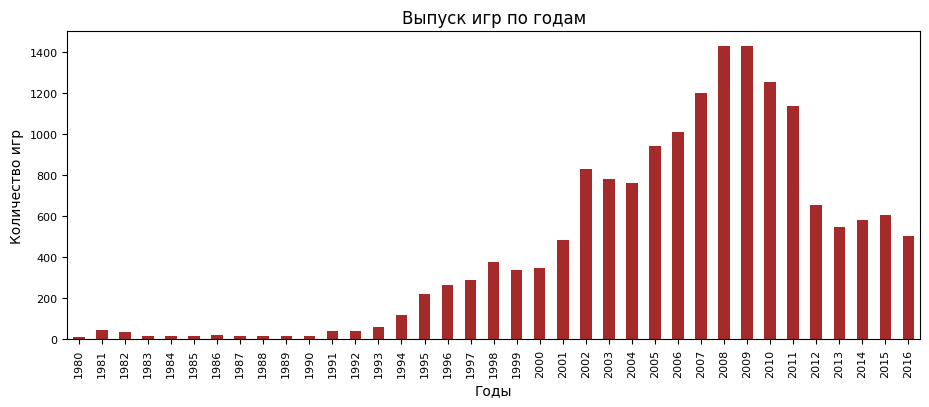

In [16]:
(
    df.groupby('year_of_release')['name']
    .agg('count')
    .plot(kind='bar',
          figsize=(11,4),
          fontsize=8,
          color='brown',
          title='Выпуск игр по годам',
          ylabel='Количество игр',
          xlabel='Годы')
);

График показывает "пик игростроения" в 2007-2011 годы, до этого периода наблюдался рост, после - спад в количестве производимых игр.<br>Данные до 1993 года являются явно "лишними" - игр на рынке было очень мало.<br>Для анализа будущих периодов, вероятно, необходимо работать с данными начиная с 2012 года, т.к.с этого периода произошла смена тендеции: игр стало меньше, произошёл качественный и количественный переход на новые технологии (возможно, причина в росте требований к производству игр, чтобы создать качественный и востребованный продукт, необходимы серьёзные начальные инвестиции, которые могут позволитт себе только крупные корпорации).

### Выпуск игр в разбивке по плаформам

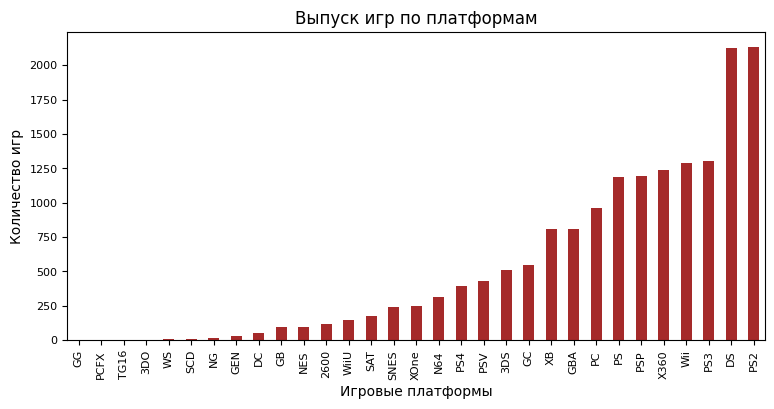

In [17]:
# анализируем данные о производстве игр по платформам
(
    df.groupby('platform')['name']
    .agg('count')
    .sort_values()
    .plot(kind='bar',
          figsize=(9,4),
          fontsize=8,
          color='brown',
          title='Выпуск игр по платформам',
          ylabel='Количество игр',
          xlabel='Игровые платформы')
);

В числе платформ лидеров совершенно ожидаемо вошли приставки фирм Nintendo, Sony, MS: PS2, DS, Wii, X360. Производство игр для ПК (PC) на 8 месте.

### Анализ продаж по платформам

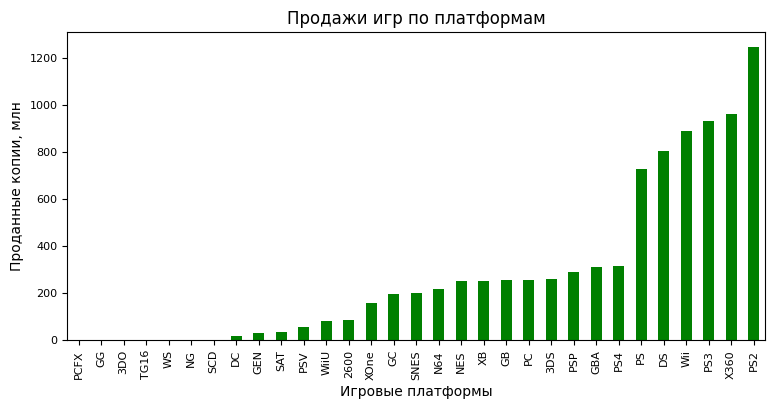

In [18]:
# анализируем данные о продажах по платформам
(
    df.groupby('platform')['total_sales'].agg('sum')
    .sort_values()
    .plot(kind='bar',
          figsize=(9,4),
          fontsize=8,
          color='green',
          title='Продажи игр по платформам',
          ylabel='Проданные копии, млн',
          xlabel='Игровые платформы')
);

Лидерами по продажам копий являются всё те же 6 платформ: PS, DS, Wii, X360. Абсолютный лидер - PS2.

### Продажи по платформам (динамика лидеров по годам)

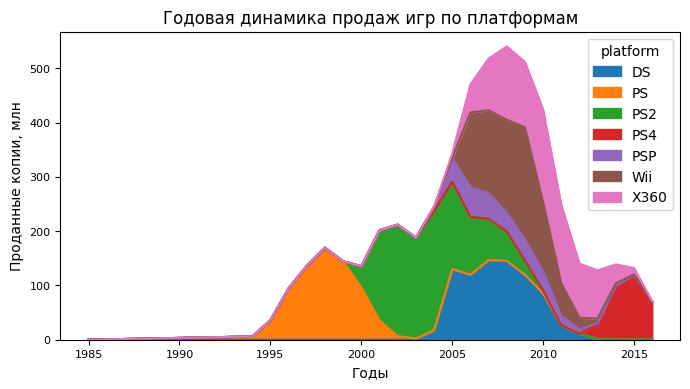

In [19]:
# анализируем данные о продажах по платформам по годам
leader_list = ['PS2', 'X360', 'PS30', 'Wii', 'DS', 'PS', 'PS4', 'PSP']
(
    df.query('platform in @leader_list')
    .pivot_table(index='year_of_release',
           columns='platform',
           values = 'total_sales',
           aggfunc='sum')
    .plot.area(
        stacked=True,
        figsize=(8,4),
        fontsize=8,
        title='Годовая динамика продаж игр по платформам',
        ylabel='Проданные копии, млн',
        xlabel='Годы')
);   


График отражает изменение продаж игр для разных платформ по годам. Можно отметить взлёты и падения продаж - одна популярная платформа сменялась другой - это характерно для развития "железа". В среднем платформа живёт порядка 10 лет, достигая пика к середине этого срока, и, затем постепенно теряя популярность (актуальность).<br> В график включёны платформы PS4 и PSP (далекие от лидерства за весь период в ДФ) для сравнения с теряющими к 2015-2016 годам популярность лидерами продаж.

### Выбор актуального периода, анализ платформ

Для построения прогнозного анализа на будущий период (в задании - 2017 год) будем работать с данными c 2012 года, к этому времени уже появились новые платформы, имеющие потенциал роста по продажам, в то время как лидеры прошлых лет(такие как PS2, X360 и Wii), уже утрачивают свои позиции. Также на рынке с этого периода произошли фундаментальные изменения, о которых мы упоминали выше, в разделе [3.1](#anchor3_1)

In [20]:
# новый ДФ
df_actual = df[df['year_of_release'] >= 2012]

Построим прошлый график с учётом этого выбора, однако, при построении ограничимся 2015 годом, учитывая, что за 2016 год данные могут быть неполными.

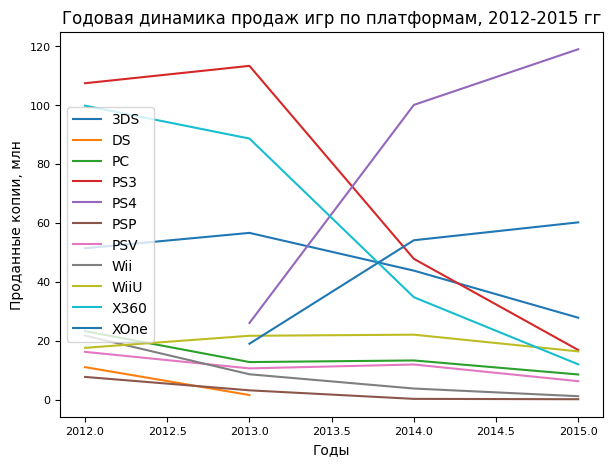

In [21]:
(
    df_actual.query('year_of_release < 2016')
    .pivot_table(index='year_of_release',
           columns='platform',
           values = 'total_sales',
           aggfunc='sum')
    .plot(
        figsize=(7,5),
        fontsize=8,
        title='Годовая динамика продаж игр по платформам, 2012-2015 гг',
        ylabel='Проданные копии, млн',
        xlabel='Годы')
);
plt.legend(loc='center left')
plt.show()

С учётом ограничения на графике (не стали брать данные за возможно неполный 2016 год) видим:
- 2 набирающие популярность платформы - PS3 и XOne. Продажи в 2015 году по этим платформам набирали рост - их можно считать перспективными
- остальные платформы показали негативную динамику по этому показателю
- или околонулевую (зато стабильную!) WiiU, PC, PSV.

### Анализ продаж по платформам в актуальном периоде

Часть платформ практически полностью теряют рынок к обозначенному периоду. Данные по ним можно удалить из ДФ для облегчения анализа. Посмотрим на данные в таблице:

In [22]:
(
   df_actual.query('year_of_release < 2017')
    .pivot_table(index='year_of_release',
           columns='platform',
           values = 'total_sales',
           aggfunc='sum')
)

platform,3DS,DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.36,NaN,7.69,16.19,21.71,17.56,99.74,NaN
2013,56.57,1.54,12.73,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,NaN,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,NaN,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,NaN,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


С рынка полностью или почти полностю ушли DS, PSP и Wii. Уберём их данные. "Безперспективняк".

In [23]:
del_list = ['DS', 'PSP', 'Wii']
df_actual = df_actual.query('platform not in @del_list')

In [24]:
df_actual.query('year_of_release < 2017').describe()

,year_of_release,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,total_sales
count,2629.000000,2629.000000,2629.000000,2629.000000,2629.000000,1306.000000,1508.000000,2629.000000
mean,2014.054774,0.216379,0.186839,0.066565,0.058087,72.246554,6.644695,0.527870
std,1.384590,0.580853,0.523233,0.243647,0.171138,12.715954,1.559381,1.283657
min,2012.000000,0.000000,0.000000,0.000000,0.000000,13.000000,0.200000,0.010000
25%,2013.000000,0.000000,0.000000,0.000000,0.000000,66.000000,5.800000,0.040000
50%,2014.000000,0.040000,0.030000,0.010000,0.010000,74.000000,7.000000,0.140000
75%,2015.000000,0.180000,0.150000,0.050000,0.050000,81.000000,7.800000,0.460000
max,2016.000000,9.660000,9.090000,4.390000,3.960000,97.000000,9.300000,21.050000


(0.0, 3.0)

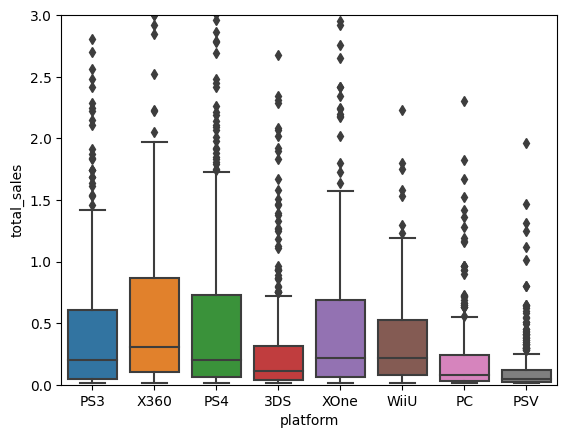

In [25]:
(
    sns.boxplot
    (
     y="total_sales",
     x='platform',
     data=df_actual.query('year_of_release < 2017'),
    )
)
plt.ylim(0, 3)

Графики 'ящик с усами' или боксплот - показывают нам структуру данных. Большая часть игр на всех платформах продавалась совсем не космическими объёмами - медианы лоцированы на уровнях 0,1 - 0,4 млн экз., 3 квартили - от 0,18 до 0,5 млн. А "выстреливают" единичные игры, которые, судя по статистике, и вовсе являются "выбросами", т.к. зачастую находятся за пределами "усов" графиков. Это игры, которые удалось продать на лидирующих платформах в объёмах более 1,5 млн копий.

### Влияние на продажи отзывов критиков и пользователей по платформе PS4
 Разберём, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков.<br>
 Для анализа выберем платформу PS4, она одна из двух перспективных.<br>
 Сначала построим диграммы рассеяния для оценки зависимости продаж и отзывов (сначала критиков, а потом и пользователей).

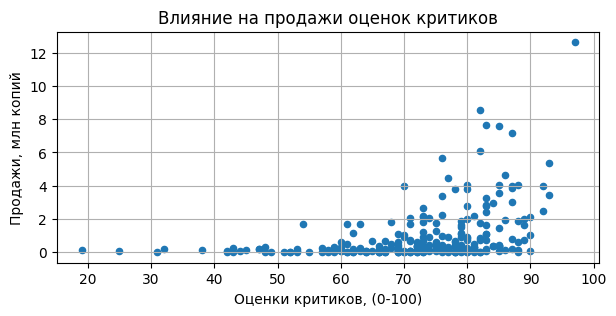

In [26]:
(
    df_actual.query('platform == "PS4"')
    .plot
    (
        x='critic_score',
        y='total_sales',
        kind='scatter',
        figsize=(7,3),
        grid=True,
        alpha=1,
        title='Влияние на продажи оценок критиков',
        ylabel='Продажи, млн копий',
        xlabel='Оценки критиков, (0-100)'
    )
);

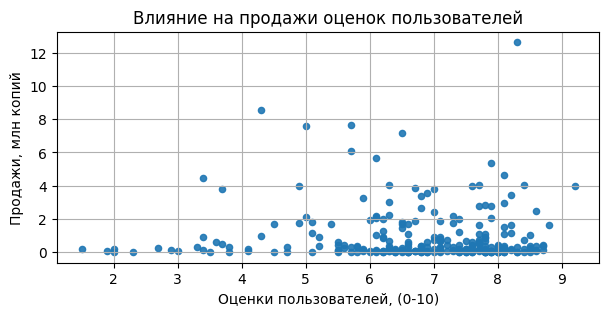

In [27]:
(
    df_actual.query('platform == "PS4"')
    .plot
    (
        x='user_score',
        y='total_sales',
        kind='scatter',
        figsize=(7,3),
        grid=True,
        alpha=0.9,
        title='Влияние на продажи оценок пользователей',
        ylabel='Продажи, млн копий',
        xlabel='Оценки пользователей, (0-10)'
    )
);

По графикам связь прослеживается плохо, дополнительно оценим корреляцию через коэффициент Пирсона:

In [28]:
print('Коэффициент Пирсона, для оценки связи между уровнем оценок критиков и объёмом продаж игр:\n',\
      df_actual.query('platform == "PS4"')['total_sales']\
      .corr(df_actual.query('platform == "PS4"')['critic_score']))

Коэффициент Пирсона, для оценки связи между уровнем оценок критиков и объёмом продаж игр:
 0.4065679020617816


In [29]:
print('Коэффициент Пирсона, для оценки связи между уровнем оценок пользователей и объёмом продаж игр:\n',\
      df_actual.query('platform == "PS4"')['total_sales']\
      .corr(df_actual.query('platform == "PS4"')['user_score']))

Коэффициент Пирсона, для оценки связи между уровнем оценок пользователей и объёмом продаж игр:
 -0.03195711020455643


Оценим корреляцию продаж и оценок пользователей и критиков для всех платформ в табличной форме.

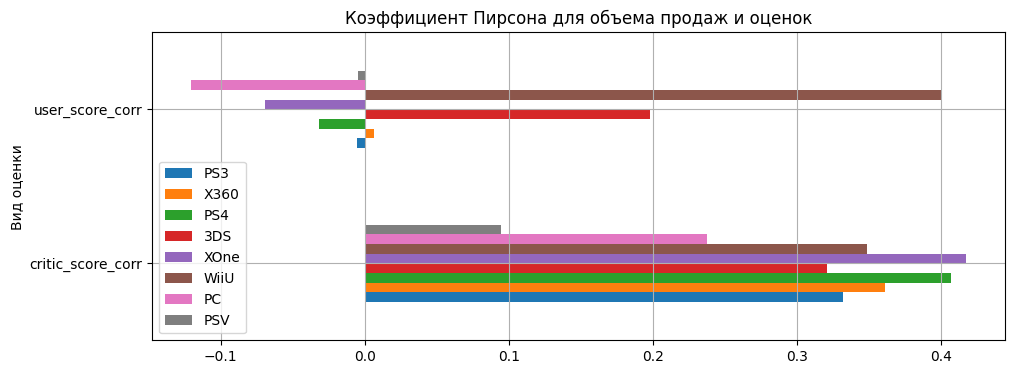

In [30]:
# лепить 8-10 одинаковых графиков не хочется. Итак уже проект - портянка!
# сделаем общую таблицу и 1 график по ней
# список платформ
platf_list = df_actual['platform'].unique().tolist()
# будущие строчки
pltf_crit={}
pltf_user={}
# пробежимся по платформам и вычислим корреляцию - сразу в словарик её
for i in platf_list:
    pltf_crit[i] = df_actual.query('platform == @i')['total_sales'].corr(df_actual.query('platform == @i')['critic_score'])
    pltf_user[i] = df_actual.query('platform == @i')['total_sales'].corr(df_actual.query('platform == @i')['user_score'])
# новая табличка
score_sales_corr = pd.DataFrame([pltf_crit, pltf_user]).set_index([['critic_score_corr','user_score_corr']])
(
    score_sales_corr
    .plot(kind='barh',
          grid=True,
          figsize=(11,4),
          title='Коэффициент Пирсона для объема продаж и оценок',
          xlabel='Вид оценки'
         )
);

Как показали рассчёты - имеется положительная корреляция между уровнем оценок критиков и уровнем продаж по всем платформам. Положительная связь не является сильной (коэффициент Пирсона не достигает 0,5) ни по одной платформе. Минимальная - у PSV (меньше 0,1), максимальная - PS3 и PS4.<p>Оценка пользователей также не имеет сильной корреляции ни по одной платформе (максимум 0,4 по WiiU и 0,2 по 3DS) с объёмом продаж, в основном, эта связь не прослеживается. По многим платформам коэффициент Пирсона находится в пределах -0.1/+0.
Итак, между продажами и уровнем оценок критиков есть хоть и не очень сильная, но положительная корреляция, в тоже самое время, между показателями продаж и отзывам пользователей корреляция слабая, но даже обратная.<br>
Можно сделать вывод о том, что обзоры критиков и лидеров общественного мнения являются авторитетными , возможно, более объёктивными, и могут оказывать какое-то влияние на динамику продаж. Отзывы пользователей могут быть субъективными, связанными с конкретными проблемами железа/софта, личными неудачами и не оказывают влияния на продажи.

### Общее распределение игр по жанрам

Для анализа распределения игр по жанрам проведём, используя две диаграммы: боксплот для общей картины распределения и столбчатая диаграмма для более детального сравнения средних и медианных продаж игр по жанрам.

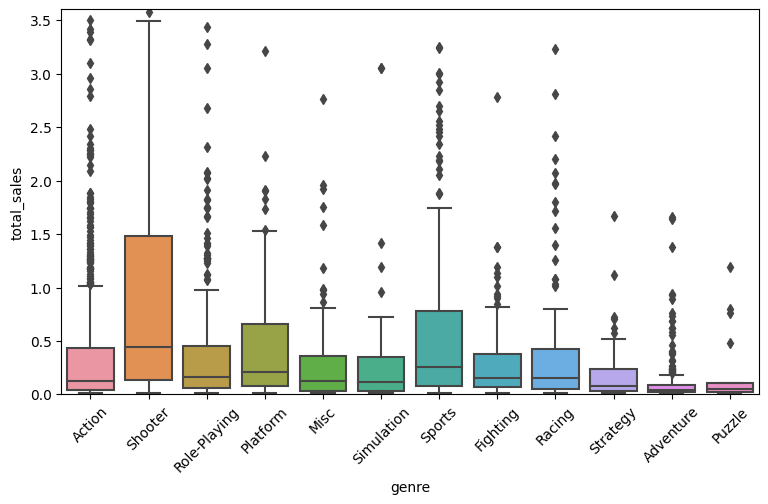

In [31]:
# сначала боксплот для анализа в первом приближени
plt.figure(figsize=(9,5))
ax = sns.boxplot(y="total_sales", x='genre', data=df_actual)
plt.xticks(rotation = 45)
plt.ylim(0, 3.6)
plt.show()

Наиболее прибыльными жанрами можно назвать те, которые показывают большее количество игр с высокими продажами. Т.е. на боксплоте сам "ящик" должен быть максимальным по размеру, охватывая область между 2 и 3 перцентилями. Соответственно, медиана также должна быть максимально высоко, как и правый (на графике - "верхний") ус должен быть максимальным. Значения за пределами (выше) усов - это формально "выбросы", т.е. единичные пики продаж - их необходимо отдельно анализировать, потому как это "звёзды" и "топчик", на которые всегда есть спрос.<br>Лидеры по "размеру ящика и усов" - Shooter, Sports, Platform. Аутсайдеры - Adventures и Puzzle.

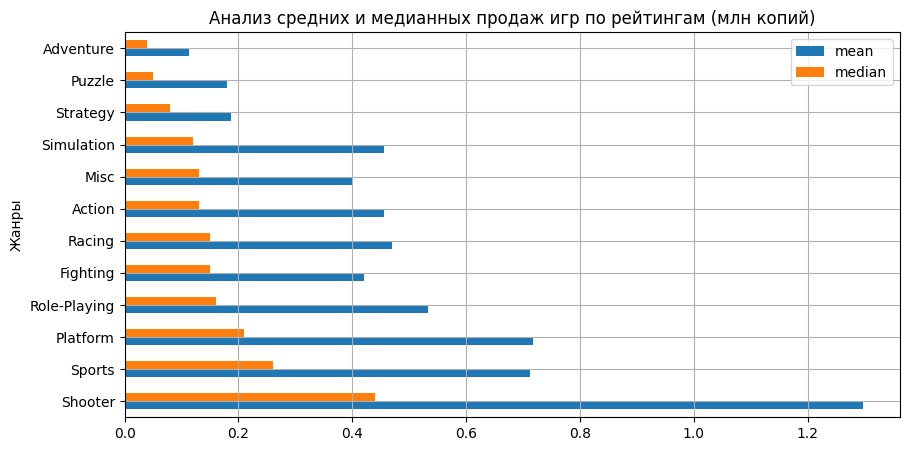

In [32]:
# столбчатый график с более детальным анализом продаж
(
    df_actual.groupby('genre')['total_sales']
    .agg(['mean', 'median'])
    .sort_values(by='median', ascending=False)
    .plot
    (
        kind='barh',
        figsize=(10,5),
        grid=True,
        title='Анализ средних и медианных продаж игр по рейтингам (млн копий)',
        xlabel='Жанры'
    )
);

Анализ средних и медиан позволяет более детально рассмотреть лидеров/аутсайдеров рейтинга прибыльности жанров. Максимальные продажи дают "шутеры" и "спорт". Показывающий максимальные общие продажи Экшн находится во второй половине рейтинга - очевидно что продажи там делаются за счёт отдельных успешных игр, оснонвная же масса - не так продаваема.
Замыкают рейтинг "приключения" и "головоломки".

In [33]:
# любопытно увидеть топ-10 игр по продажам
(
    df_actual[['name', 'year_of_release', 'genre','platform', 'total_sales']]
    .sort_values(by='total_sales', ascending=False)
    .head(10)
)

,name,year_of_release,genre,platform,total_sales
16,Grand Theft Auto V,2013,Action,PS3,21.05
23,Grand Theft Auto V,2013,Action,X360,16.27
31,Call of Duty: Black Ops 3,2015,Shooter,PS4,14.63
33,Pokemon X/Pokemon Y,2013,Role-Playing,3DS,14.60
34,Call of Duty: Black Ops II,2012,Shooter,PS3,13.79
35,Call of Duty: Black Ops II,2012,Shooter,X360,13.68
42,Grand Theft Auto V,2014,Action,PS4,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,2014,Role-Playing,3DS,11.68
60,Call of Duty: Ghosts,2013,Shooter,X360,10.24
62,New Super Mario Bros. 2,2012,Platform,3DS,9.90


Догадка косвенно подтвердилась - жанр Экшн выходит в топы во многом за счёт одной звезды - ГТА5  (*но, конечно, не только из-за неё!), которая бьёт все рекорды по популярности на многих платформах. В топ-10 ГТА5 встречается аж 4 раза.

## Портрет пользователя каждого региона

### Оценка популярности игровых платформ по регионам

In [34]:
pop_platform =\
    df_actual.groupby('platform')\
    [['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales']]\
    .sum()

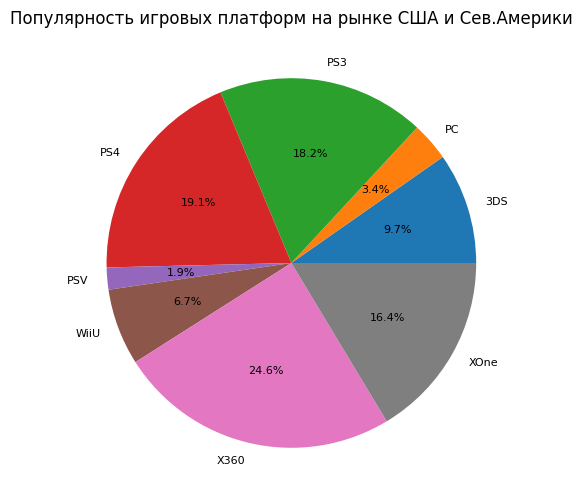

In [35]:
# для США и Северной Америки
(
    pop_platform['na_sales']
    .plot
    (
        kind = 'pie',
        title='Популярность игровых платформ на рынке США и Сев.Америки',
        ylabel='',
        autopct='%1.1f%%',
        fontsize=8,
        figsize=(6,6)
     )
);

Для рынка США и Северной Америки самая популярная платформа - X360, второе место делят с небольшой разницей XOne, PS3 и PS4

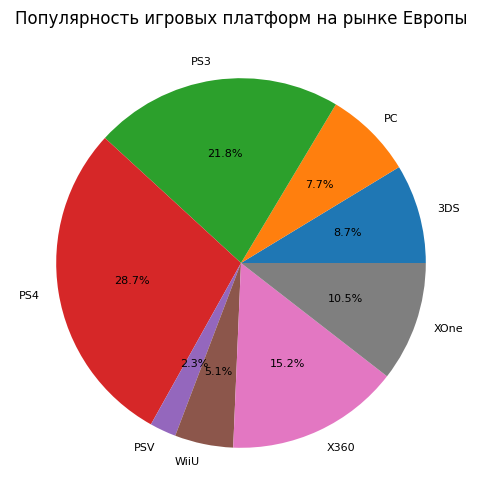

In [36]:
# для рынка Европы
(
    pop_platform['eu_sales']
    .plot
    (
        kind = 'pie',
        title='Популярность игровых платформ на рынке Европы',
        ylabel='',
        fontsize=8,
        figsize=(6,6),
        autopct='%1.1f%%'
    )
);

Для рынка Европы самая популярная платформа -  PS4, немного отстаёт PS3, а популярный в США XOne всего лишь на 4-5 месте

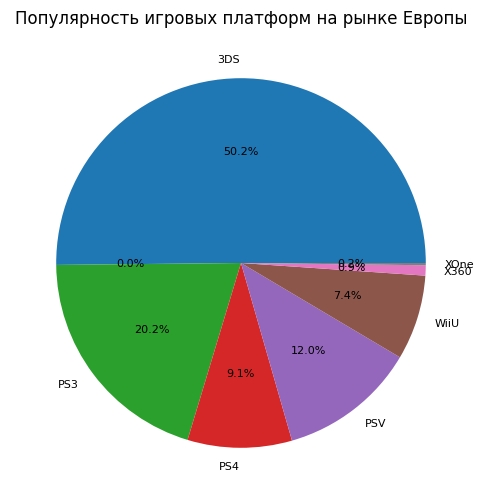

In [37]:
# для рынка Японии
(
    pop_platform['jp_sales']
    .plot
    (
        kind = 'pie',
        title='Популярность игровых платформ на рынке Европы',
        ylabel='',
        fontsize=8,
        figsize=(6,6),
        autopct='%1.1f%%'
    )
);

Рынок Японии стоит особняком - здесь структура лидеров совсем иная. Абсолютный лидер (около 50% продаж) - 3DS, платформы XOne вообще не видно.

Вывод: разные региональные рынки "поделены" между разными платформами. И если рынки США и Европы во многом похожи по структуре и набору лидеров, то рынок Японии кардинально отличается.

### Оценка популярности жанров игр по регионам

Создадим отдельный ДФ для анализа популярности жанров для разных рынков

In [38]:
pop_genre =\
    df_actual.groupby('genre')\
    [['na_sales', 'eu_sales', 'jp_sales', 'other_sales', 'total_sales']]\
    .sum()

Выберем топ-5 по объёму продаж для каждого региона

In [39]:
# жанры для США и Северной Америки
pop_genre_na = pop_genre.sort_values(by='na_sales', ascending=False).head(5).reset_index()
pop_genre_na = pop_genre_na[['genre', 'na_sales']]

# жанры для Европы
pop_genre_eu = pop_genre.sort_values(by='eu_sales', ascending=False).head(5).reset_index()
pop_genre_eu = pop_genre_eu[['genre', 'eu_sales']]

# жанры для Японии
pop_genre_jp = pop_genre.sort_values(by='jp_sales', ascending=False).head(5).reset_index()
pop_genre_jp = pop_genre_jp[['genre', 'jp_sales']]

Склеим все топ-5 в одну таблицу для наглядности иллюстрации.

In [40]:
pop_genre_5top = pop_genre_na.merge(pop_genre_eu, on='genre', how='outer')
pop_genre_5top = pop_genre_5top.merge(pop_genre_jp, on='genre', how='outer')
pop_genre_5top = pop_genre_5top.set_index('genre')
pop_genre_5top.columns = ['США', 'Европа', 'Япония']

Посмотрим на визуализацию собранных данных:

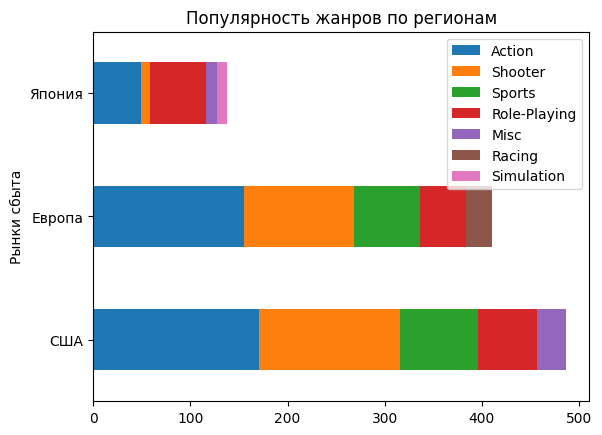

In [41]:
ax = pop_genre_5top.transpose()\
.plot.barh(title='Популярность жанров по регионам', ylabel='Рынки сбыта', stacked=True)
plt.legend(loc='upper right')
plt.show();

Анализируя диаграмму популярности жанров, можно сделать выводы:
- жанр Action очень популярен на всех рынках (1 место в США и Европе, 2 - в Японии), 1 место в Японии - RPG
- на втором месте в США и Европе - Shooter
- лидер японского топ-5 RPG - в США и Европе также достаточоно популярен, но только на 4-м месте в топ-5
- на третьем месте в США и Европе спортивные игры (Sports), в Японии этот жанр вообще в топ-5 не входит
- рынки США и Европы досточно схожи по структуре, отличия только в 5-м месте: в США это "прочие" (Misc), а в Европе - гонки (Racing)

### Влияние рейтинга на продажи в разных регионах

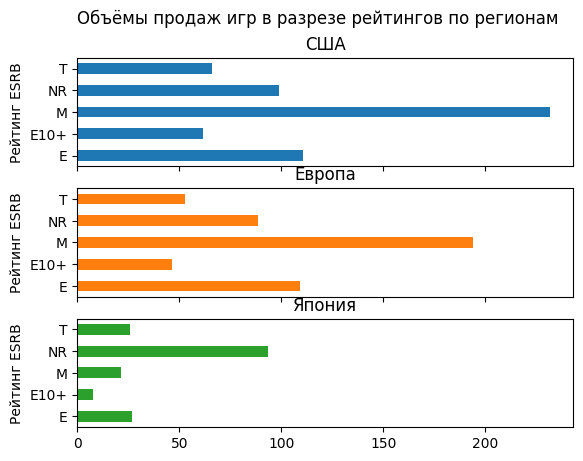

In [42]:
# создаём две таблички для разных графиков 
#1
region_rating = df_actual.groupby('rating')[['na_sales', 'eu_sales', 'jp_sales']].sum()
#2
rt = region_rating.transpose()

# работаем с 1
region_rating.columns = ['США', 'Европа', 'Япония']
ax = region_rating.plot.\
barh\
(title='Объёмы продаж игр в разрезе рейтингов по регионам', subplots=True, xlabel = 'Рейтинг ESRB', legend=False)

In [43]:
# теперь работаем с 2 табличкой, приводим все абсолютные значения к долям от 1

# считаем столбец с суммой
rt.loc[:,'total'] = rt.sum(axis=1)
# создаем столбцы с долей от суммы
rt['E_share'] = rt['E'] / rt['total']
rt['E10+_share'] = rt['E10+'] / rt['total']
rt['M_share'] = rt['M'] / rt['total']
rt['NR_share'] = rt['NR'] / rt['total']
rt['T_share'] = rt['T'] / rt['total']
# удаляем лишние
rt = rt.iloc[:, -5:]

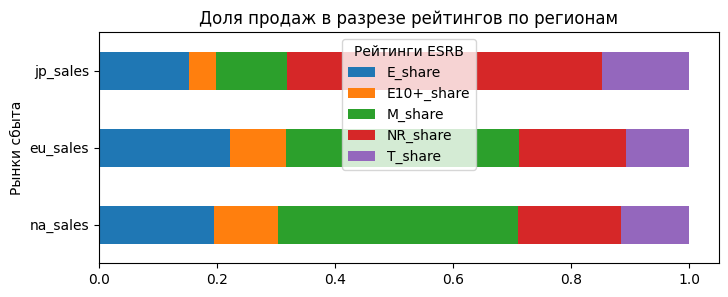

In [44]:
# график-структура в относительных величинах - долях
ax = rt.plot.barh\
(figsize=(8,3),title='Доля продаж в разрезе рейтингов по регионам', ylabel='Рынки сбыта', stacked=True)
plt.legend(loc='upper center', title='Рейтинги ESRB')
plt.show();

Entertainment Software Rating Board (ESRB) — негосударственная организация, основное направление деятельности — принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде.
Обозначения:
- «E» («Everyone») — «Для всех» (0+)
- «E10+» («Everyone 10 and older») — «Для всех от 10 лет и старше» (10+)
- «T» («Teen») — «Подросткам» (13+)
- «M» («Mature») — «Для взрослых» (17+)
- NR - принятое в ходе данного исследования обозначение при отсутсвии данных о рейтинге ESRB<br>

По представленным графикам можно сделать вывод, что основная доля продаж приходится на игры для взрослых в США и Европе (очевидно, выплывают всё те же "шутеры" и "экшн"), в Японии - основная доля приходится на игры без рейтинга (вероятно, это связано с популярностью отечественных разработчиков, которые не стремятся получать рейтинг в США/Европе, т.к. в Японии есть своё аналогичное агентство CERO - для японцев важнее эти оценки).<br>Доли игр "без ограничений" примерно везде равны, как и сопоставимы доли игр для категории "13+"


## Проверка гипотез

### Средние пользовательские рейтинги платформ Xbox One и PC одинаковые

In [45]:
# выделим для удобства работы сравниваемые выборки в отдельные переменные
# xb
xbox_user_score = df.query('platform =="XB" & user_score > 0').reset_index(drop=True)
xbox_user_score = xbox_user_score[['user_score']]
#pc
pc_user_score = df.query('platform =="PC" & user_score > 0').reset_index(drop=True)
pc_user_score = pc_user_score[['user_score']]

# сразу оценим объём выборок
(pc_user_score.shape[0], xbox_user_score.shape[0])

(756, 574)

Имеем 2 выборки по нескольким сотням наблюдений, можно применять методы стат.анализа.<br>Сначала оценим нормальность распределения.

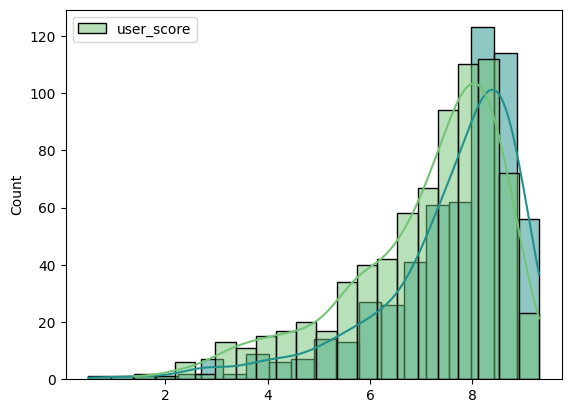

In [46]:
sns.histplot(xbox_user_score, kde=True, bins=20, palette='viridis');
sns.histplot(pc_user_score, kde=True, bins=20, palette='Greens');

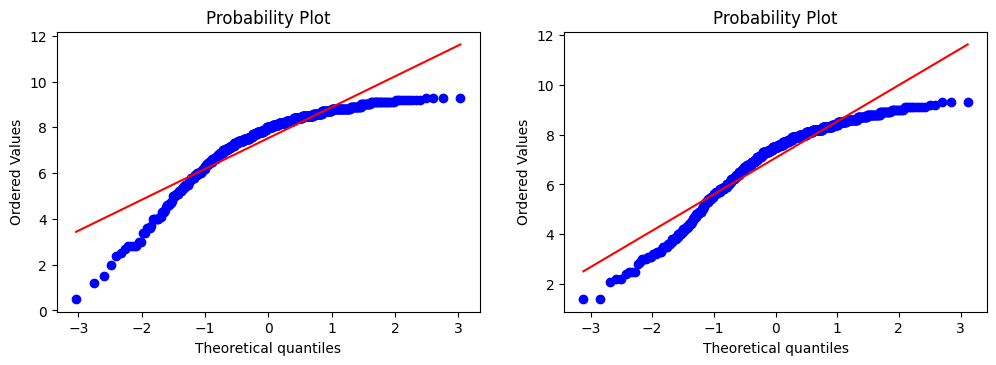

In [47]:
# строим qq-plot для оценки нормального распределения
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
st.probplot(xbox_user_score['user_score'], dist="norm", plot=plt)
plt.subplot(2,2,2)
st.probplot(pc_user_score['user_score'], dist="norm", plot=plt)
plt.show()

Графический анализ не позволяет утверждать, что данные выборки являются нормально распределёнными (гистограмма значительно смещена вправо, а на qq-тестах отмечается сильное отклонение от "идеальной" прямой).<br><br>Дополнительно проведём проверку методом Шапиро-Уилка.

In [48]:
# пороговое значение примем за 5%
alpha=0.05

Нулевая гипотеза для метода Шапиро-Уилка: если результирующая p-value меньше alpha, значит данные не позволяют утверждать, что выборка нормально распределена. Альтернативная гипотеза - выборка нормально распределена

In [49]:
results = st.shapiro(xbox_user_score)
print('pvalue для выборки по XBox =', results.pvalue)
if results.pvalue < alpha:
    print('Не получилось отвергнуть нулевую гипотезу для выборки по Xbox, вероятно, выборка распределена ненормально')
else:
    print('Отвергаем нулевую гипотезу для выборки по Xbox, выборка распределена нормально')

pvalue для выборки по XBox = 2.9255622955823163e-23
Не получилось отвергнуть нулевую гипотезу для выборки по Xbox, вероятно, выборка распределена ненормально


In [50]:
results = st.shapiro(pc_user_score)
print('pvalue для выборки по PC =', results.pvalue)
if results.pvalue < alpha:
    print('Не получилось отвергнуть нулевую гипотезу для выборки по Xbox, вероятно, выборка распределена ненормально')
else:
    print('Отвергаем нулевую гипотезу для выборки по Xbox, выборка распределена нормально')

pvalue для выборки по PC = 2.45366770894125e-21
Не получилось отвергнуть нулевую гипотезу для выборки по Xbox, вероятно, выборка распределена ненормально


Вывод: предварительная оценка подтверждена - обе выборки не являются нормально распределёнными. Для сравнения их средних необходимо использовать непараметрический метод (Манна-Уитни)

Сформулируем нулевую и альтернативную гипотезы:
<li>0. Средние оценки пользователей по игровым платформам XBox и PC равны</li>
<li>1. Средние оценки пользователей по игровым платформам XBox и PC отличаются</li>
<p>
Если рассчитанный методом p-значение будет меньше порогового значения 0,05 - мы отвергаем 0 гипотезу, в обратном случае - нет оснований отвергать её.
<p>
При анализе исходим из того, что выборки независимы, их дисперсии различны.

In [51]:
results = st.ttest_ind(xbox_user_score, pc_user_score, alternative='two-sided', equal_var=False)
print('p-value =', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу, по имеющимся данным средние оценки отличаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу, по имеющимся данным средние оценки равны")

p-value = [2.6902743e-08]
Отвергаем нулевую гипотезу, по имеющимся данным средние оценки отличаются


In [52]:
# ради спортивного интереса оценим средние в абсолютном выражении
(xbox_user_score.mean(), pc_user_score.mean())

(user_score    7.530488
 dtype: float64,
 user_score    7.067857
 dtype: float64)

Вывод: согласно проведённым статтестам, по имеющимся данным нельзя утверждать, что средние оценки пользователей платформ XBox и PC одинаковы.

### Средние пользовательские рейтинги жанров Action и Sports разные

In [53]:
# снова выделим для удобства работы сравниваемые выборки в отдельные переменные
# action
action_user_score = df.query('genre =="Action" & user_score > 0').reset_index(drop=True)
action_user_score = action_user_score[['user_score']]

# sports
sports_user_score = df.query('genre =="Sports" & user_score > 0').reset_index(drop=True)
sports_user_score = sports_user_score[['user_score']]

# оценим объём выборок
(action_user_score.shape[0], sports_user_score.shape[0])

(1797, 1088)

Объём выборок достаточно большой. Приступим к проверке на нормальное распределение.

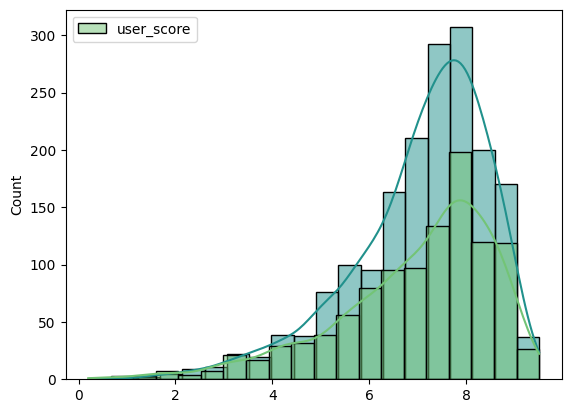

In [54]:
sns.histplot(action_user_score, kde=True, bins=20, palette='viridis');
sns.histplot(sports_user_score, kde=True, bins=20, palette='Greens');

Также, как и в прошлых выборках, большинство пользователей щедры на высокие оценки - выборки смещены вправо, наибольшая частота у оценок 7,5-8 баллов.

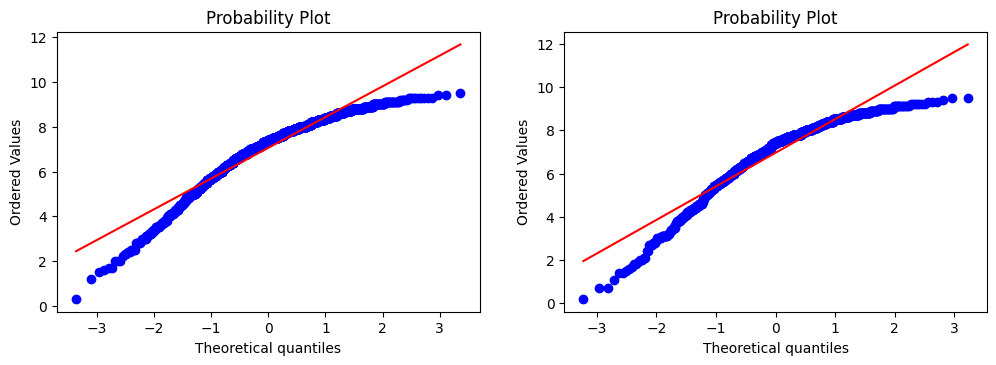

In [55]:
# строим qq-plot для оценки нормального распределения
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
st.probplot(action_user_score['user_score'], dist="norm", plot=plt)
plt.subplot(2,2,2)
st.probplot(sports_user_score['user_score'], dist="norm", plot=plt)
plt.show()

Графический анализ не позволяет утверждать, что данные выборки являются нормально распределёнными (гистограммы смещены вправо, а на qq-тестах отмечаются "хвосты").<br><br>Дополнительно проведём проверку методом Шапиро-Уилка.

Нулевая гипотеза для метода Шапиро-Уилка: если результирующая p-value меньше alpha, значит данные не позволяют утверждать, что выборка нормально распределена. Альтернативная гипотеза - выборка нормально распределена. <br><br>Пороговое значение alpha оставляем прежним 0,05.

Нулевая гипотеза для метода Шапиро-Уилка: если результирующая p-value меньше alpha, значит данные не позволяют утверждать, что выборка нормально распределена. Альтернативная гипотеза - выборка нормально распределена

In [56]:
results = st.shapiro(action_user_score)
print('pvalue для выборки оценок по жанру Action =', results.pvalue)
if results.pvalue < alpha:
    print('Не получилось отвергнуть нулевую гипотезу для выборки оценок по жанру Action, вероятно, выборка распределена ненормально')
else:
    print('Отвергаем нулевую гипотезу для выборки оценок по жанру Action, выборка распределена нормально')

pvalue для выборки оценок по жанру Action = 2.0082653754397346e-28
Не получилось отвергнуть нулевую гипотезу для выборки оценок по жанру Action, вероятно, выборка распределена ненормально


In [57]:
results = st.shapiro(sports_user_score)
print('pvalue для выборки оценок по жанру Sports =', results.pvalue)
if results.pvalue < alpha:
    print('Не получилось отвергнуть нулевую гипотезу для выборки оценок по жанру Sports, вероятно, выборка распределена ненормально')
else:
    print('Отвергаем нулевую гипотезу для выборки оценок по жанру Sports, выборка распределена нормально')

pvalue для выборки оценок по жанру Sports = 6.256914167493778e-24
Не получилось отвергнуть нулевую гипотезу для выборки оценок по жанру Sports, вероятно, выборка распределена ненормально


Вывод: предварительная оценка вновь подтверждена - нельзя утверждать, что обе выборки являются нормально распределёнными. Для сравнения их средних необходимо использовать непараметрический метод (Манна-Уитни)

Сформулируем нулевую и альтернативную гипотезы:
<li>0. Средние оценки пользователей для игр по жанрам Action и Sports равны</li>
<li>1. Средние оценки пользователей для игр по жанрам Action и Sports равны отличаются</li>
<p>
Нулевая гипотеза выбрана обратной от поставленной задачи, т.к. стат. методы на основе p-value оценивает вероятность ошибки при равенстве средних. Если равенство оценок не подтвердится, получим положительный ответ на поставленный исходный вопрос.
<p>
Итак, если рассчитанное p-значение будет меньше порогового значения 0,05 - мы отвергаем 0 гипотезу, в обратном случае - нет оснований отвергать её.

In [58]:
results = st.mannwhitneyu(action_user_score, sports_user_score, alternative='two-sided')
print('p-value =', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу, по имеющимся данным средние оценки жанров Action и Sports наиболее вероятно отличаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу, по имеющимся данным средние оценки жанров Action и Sports наиболее вероятно равны")

p-value = [0.67504012]
Не получилось отвергнуть нулевую гипотезу, по имеющимся данным средние оценки жанров Action и Sports наиболее вероятно равны


In [59]:
# вновь ради спортивного интереса оценим средние в абсолютном выражении
(sports_user_score.mean(), action_user_score.mean())

(user_score    6.959467
 dtype: float64,
 user_score    7.058932
 dtype: float64)

Вывод: согласно проведённым статтестам, по имеющимся данным нельзя утверждать, что средние оценки пользователей оценки жанров Action и Sports различаются, наиболее вероятно, что они равны.

## Общий вывод

В ходе выполнения проекта была поставлена задача найти точки роста и перспективы развития на будущий период для магазина компьютерных игр.<br>В качестве исходных данных получен набор данных, содержащих информацию о выпуске, продажах и популярности игр для разных платформ в разных регионах. Предоставленные данные достаточно высокого качества, с небольшим количеством пропусков по критическим параметрам. Много пропусков было в оценочных графах (оценки критиков и пользователей, а также рейтинги).<p>Исследовательский анализ данных позволил выявить общие тенденции в развитиие рынка игр - было отмечено общее снижение количества выпускаемых игр и сокращение количества платформ.<br> Выяснилось, что игровая платформа имеет срок жизни порядка 8-10 лет, и текущие лидеры по продажам (PS2, X360, Wii) уже теряют актуальность и находятся на излёте популярности.<p> Были выявлены платформы, в последние годы только набирающие популярность и/или находящиеся на пике - они наиболее перспективны в будущих периодах, это XOne и PS4.<p> Было выявлено, что отзывы критиков слабо влияют на объём продаж игр, а отзывы других пользователей зачастую вообще не оказывают влияния. Ориентироваться на эти показатели нельзя.<p>Анализ прибыльности игр в завимости от жанра показал абсолютное лидерство игр жанров Shooter, Sports и Platform, игры этих жанров чаще всего показывают высокие продажи в общей массе вне зависимости от высоких продаж по отдельным играм, аутсайдеры: Puzzle и Adventures.<p>Удалось выявить основные черты портрета пользователя:</p>
- на рынке США и Европы более популярна платформы X360, PS4, PS3, XOne, при этом среди жанров предпочтение отдаётся Action и Shooter, а большинство игр имеют рейтинг ESBR
- в Японии половину рынка занимают игры для платформы 3DS, на 2 и 3 местах PS3 и PS4, наиболее популярные жанры Action и RPG, наличие рейтинга ESBR значения для большинства пользователей не имеет.

Кроме того, была проведена проверка статистическими методами гипотез:
- о равенстве средних оценок пользователей платформ XBox и PC: по результатам проверки гипотезу пришлось отвергнуть (разница в оценках существенна)
- о неравенстве средних оценок пользователей игр жанров Action и Sports: по результатам проверки эту гипотезу также пришлось отвергнуть (разница в оценках оказалась несущественной).
